In [16]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[1])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,SplitOperatorPDEModel,OperatorPDEModel
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM

In [17]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os


In [18]:
def get_data_rand_coll(n_coll, n_obs,seed, data_for_pinn = False): 
    '''
    n_coll (int) : Integer less than 101 x 256.
    n_obs (int)    : Integet less than 101 x 256.
    seed (int)     : Seed to choose data point set.
    '''     
    # Generate data
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten()[:,None])
    # # Scale t
    # scaler_t = MinMaxScaler()
    # t = scaler_t.fit_transform(t)
    # x
    x = np.real(data['x'].flatten()[:,None])
    # # Scale x
    # scaler_x = MinMaxScaler()
    # x = scaler_x.fit_transform(x)
    # u true values
    Exact = np.real(data['usol'])

    # Fine meshgrid
    T, X = np.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    # Fine u values
    u_star = Exact.flatten()[:,None]
    
    # Triples at collocation point set
    N_all = n_coll
    triplets_fine = np.hstack([X_star,u_star])
    triplets_all = jax.random.choice(key = jax.random.PRNGKey(0), a = triplets_fine, shape = (N_all,), replace=False)
    
    # Collocation point set
    tx_all = triplets_all[:,:2]


    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_fine, shape = (N_obs,), replace=False)
    # triplets_obs = triplets_all[idx_obs,:] # Choose data point set from full point set
    # Data point set
    tx_obs = triplets_obs[:,:2]
    u_obs = triplets_obs[:,-1]

    u_star = triplets_fine[:,-1]

    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])
    
    return tx_obs, u_obs, tx_all, u_star, X_star

In [19]:
def get_data_unif_coll(n_coll_t, n_coll_x, n_obs, seed, data_for_pinn = False):  
    '''
    n_coll_t (int) : Integer less than 101.
    n_coll_x (int) : Integer less than 256.
    n_obs (int)    : Integet less than n_coll_t x n_coll_x.
    seed (int)     : Seed to choose data point set.
    '''  
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten())
    # Scale t
    # scaler_t = MinMaxScaler()
    # t = scaler_t.fit_transform(t)
    # x
    x = jnp.real(data['x'].flatten())
    # Scale x
    # scaler_x = MinMaxScaler()
    # x = scaler_x.fit_transform(x)
    # u true values
    Exact = jnp.real(data['usol'])

    # Fine meshgrid
    T, X = jnp.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = jnp.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    lb, ub = X_star.min(0), X_star.max(0)    
    # Fine u values
    u_star = Exact.flatten()[:,None]
    triplets_fine = jnp.hstack([X_star,u_star])


    # Triples at collocation point set
    idx_t_all = jnp.round(jnp.linspace(0, len(t) - 1, n_coll_t)).astype(int)
    t_all = t[idx_t_all]
    idx_x_all = jnp.round(jnp.linspace(0, len(x) - 1, n_coll_x)).astype(int)
    x_all = x[idx_x_all]
    # Collocation meshgrid
    T_all, X_all = jnp.meshgrid(t_all,x_all)
    # Collocation_pairs
    tx_all = np.hstack((T_all.flatten()[:,None], X_all.flatten()[:,None]))

    def is_in_array2(coords, array2):
        # Compare each coordinate pair to all rows in array2 and return True if it matches any row
        return jnp.any(jnp.all(coords == array2, axis=1))
    check_inclusion = jax.vmap(lambda row: is_in_array2(row[:2], tx_all))

    coords_to_check = triplets_fine[:,:2]
    triplets_all = triplets_fine[check_inclusion(coords_to_check)]

    # Collocation point set
    tx_all = triplets_all[:,:2]

    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_all, shape = (N_obs,), replace=False)
    triplets_train = triplets_obs[:int(N_obs*0.8),:]
    triplets_val = triplets_obs[int(N_obs*0.8):,:]

    # Data point set
    tx_train = triplets_train[:,:2]
    u_train = triplets_train[:,-1]

    # Validation point set
    tx_val = triplets_val[:,:2]
    u_val = triplets_val[:,-1]


    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])

    u_star = triplets_fine[:,-1]

    return tx_train, u_train, tx_val, u_val, tx_all, lb, ub, u_star, X_star

In [20]:
n_coll_t = 30
n_coll_x=30
n_obs = 50
run = 100

tx_obs, u_obs, tx_all, u_star, X_star = (
    get_data_rand_coll(n_coll = 500,n_obs = n_obs,seed=run)
)
tx_all = jnp.vstack([tx_all,jnp.vstack([jnp.zeros(30),jnp.linspace(-8,8,30)]).T])

# # if using val
# tx_obs = jnp.vstack([tx_train,tx_val])
# u_obs  = jnp.concatenate([u_train,u_val]).flatten()    

# Run 1_5 step method

u_operators = (eval_k,)
feature_operators = (eval_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,1.])))

# RKHS class for u
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
    .reshape(
            len(tx_all),
            len(feature_operators),
            order = 'F'
        )
)

# Choose kernel for P
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
P_model = OperatorModel(k_P)

[2.03724345 2.01946685]


In [21]:
# Equation model that has u and P object
EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_all,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

# Optimize - LM
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)
p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,1e-3,100,print_every = 10,overall_regularization=1e-15)
# u_params
u_sol = p_adjusted[:u_model.num_params]
# u_true 
u_true = u_star.flatten()
# get error
error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_sol))

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.001415, Jres = 5.963, alpha = 0.08333, improvement_ratio = 1.018
Iteration 1, loss = 0.001149, Jres = 1.368, alpha = 0.06944, improvement_ratio = 1.013
Iteration 2, loss = 0.0009086, Jres = 0.4276, alpha = 0.05787, improvement_ratio = 1.048
Iteration 3, loss = 0.0006964, Jres = 0.1518, alpha = 0.04823, improvement_ratio = 1.038
Iteration 4, loss = 0.0005263, Jres = 0.4371, alpha = 0.04019, improvement_ratio = 1.028
Iteration 5, loss = 0.0004025, Jres = 0.6631, alpha = 0.03349, improvement_ratio = 1.012
Iteration 100, loss = 8.725e-08, Jres = 0.06531, alpha = 8.333e-07, improvement_ratio = 0.9197
Iteration 200, loss = 4.507e-08, Jres = 0.000759, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 3.453e-08, Jres = 0.0005532, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 2.904e-08, Jres = 0.0001427, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 2.554e-08, Jres = 7.921e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0, loss = 2.5374999313338723e-08
Iteration 10, loss = 2.5371658139662237e-08
Iteration 20, loss = 2.5254407847174143e-08
Iteration 30, loss = 2.2777096358319997e-08
Iteration 40, loss = 1.9487626330833297e-08
Iteration 50, loss = 1.7359486150815728e-08
Iteration 60, loss = 1.576323862427244e-08
Iteration 70, loss = 1.4488391220165338e-08
Iteration 80, loss = 1.3456216106448132e-08
Iteration 90, loss = 1.2623319057449933e-08


In [42]:
fine_features = EqnModel.get_single_eqn_features(u_model,u_sol,X_star)
input_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_all)

P_parameters = p_adjusted[u_model.num_params:]

feature_predicted_ut = P_model.predict_new(fine_features,input_features,P_parameters)
ut_target = u_model.evaluate_operators((dt_k,),X_star,u_sol)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Feature predicted ut")
plt.tricontourf(X_star[:,0],X_star[:,1],feature_predicted_ut,30)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("ut from differentiation")
plt.tricontourf(X_star[:,0],X_star[:,1],ut_target,30)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Error between ut from differentiation and ut from features")
plt.tricontourf(X_star[:,0],X_star[:,1],ut_target - feature_predicted_ut,100)
plt.xlim(-0.1,10.1)
# plt.ylim(-10,10)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 1)
plt.show()

print("Norm of equation error ",jnp.linalg.norm(ut_target - feature_predicted_ut))

AttributeError: 'SplitOperatorPDEModel' object has no attribute 'get_single_eqn_features'

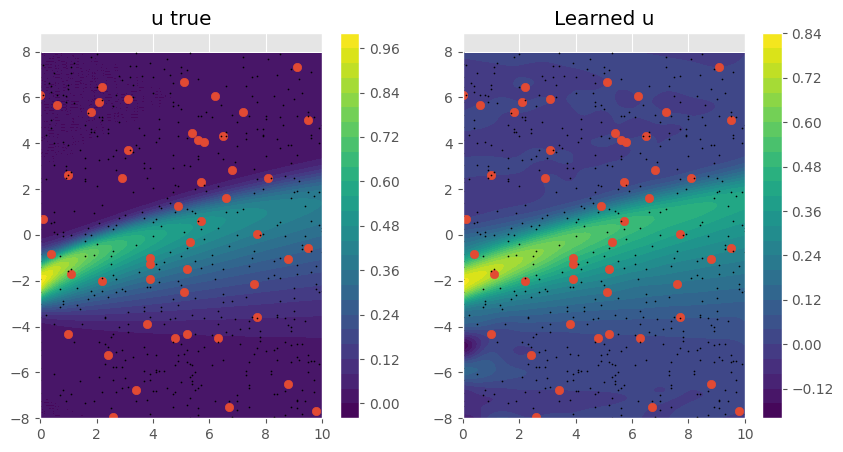

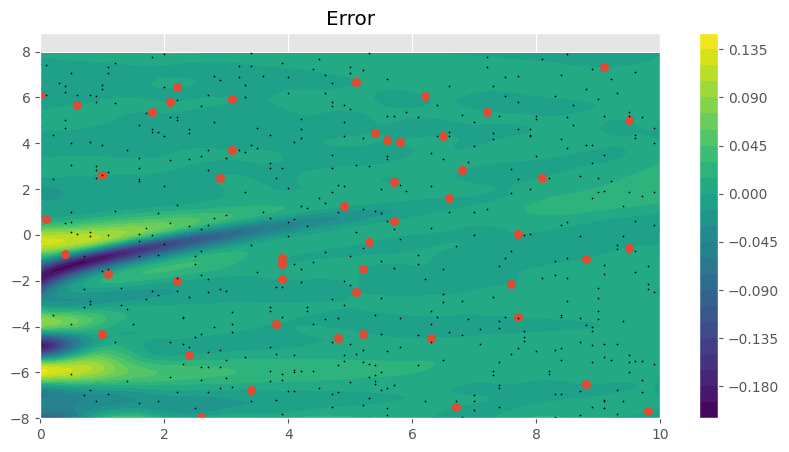

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.tricontourf(X_star[:,0],X_star[:,1],u_true,30)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1])
plt.scatter(tx_all[:,0],tx_all[:,1],s=0.5,c='black')
plt.title("u true")
plt.subplot(1,2,2)
plt.tricontourf(X_star[:,0],X_star[:,1],u_model.point_evaluate(X_star,u_sol),30)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1])
plt.scatter(tx_all[:,0],tx_all[:,1],s=0.5,c='black')
plt.title("Learned u")
plt.show()

error = u_model.point_evaluate(X_star,u_sol) - u_true

plt.figure(figsize=(10,5))
plt.tricontourf(X_star[:,0],X_star[:,1],error,30)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1])
plt.scatter(tx_all[:,0],tx_all[:,1],s=0.5,c='black')
plt.title("Error")
plt.show()


In [41]:
jnp.linalg.norm(error)/jnp.linalg.norm(u_true)

Array(0.11833972, dtype=float64)

In [43]:
# Equation model that has u and P object
EqnModel = SplitOperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_all,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

# Optimize - LM
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)
p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,1e-3,100,print_every = 10,overall_regularization=1e-15)
# u_params
u_sol = p_adjusted[:u_model.num_params]
# u_true 
u_true = u_star.flatten()
# get error
error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_sol))

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.001415, Jres = 5.963, alpha = 0.08333, improvement_ratio = 1.018
Iteration 1, loss = 0.001149, Jres = 1.368, alpha = 0.06944, improvement_ratio = 1.013
Iteration 2, loss = 0.0009086, Jres = 0.4276, alpha = 0.05787, improvement_ratio = 1.048
Iteration 3, loss = 0.0006964, Jres = 0.1518, alpha = 0.04823, improvement_ratio = 1.038
Iteration 4, loss = 0.0005263, Jres = 0.4371, alpha = 0.04019, improvement_ratio = 1.028
Iteration 5, loss = 0.0004025, Jres = 0.6631, alpha = 0.03349, improvement_ratio = 1.012
Iteration 100, loss = 8.725e-08, Jres = 0.06518, alpha = 8.333e-07, improvement_ratio = 0.9194
Iteration 200, loss = 4.507e-08, Jres = 0.000781, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 3.453e-08, Jres = 0.0005541, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 2.904e-08, Jres = 0.0001508, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 2.554e-08, Jres = 7.802e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0, loss = 2.5374994511056017e-08
Iteration 10, loss = 2.537165334836487e-08
Iteration 20, loss = 2.5254403187992522e-08
Iteration 30, loss = 2.2777091886573764e-08
Iteration 40, loss = 1.94876440200217e-08
Iteration 50, loss = 1.735950687206551e-08
Iteration 60, loss = 1.5763251524823656e-08
Iteration 70, loss = 1.4488399902730916e-08
Iteration 80, loss = 1.3456212309553785e-08
Iteration 90, loss = 1.2623317297601813e-08


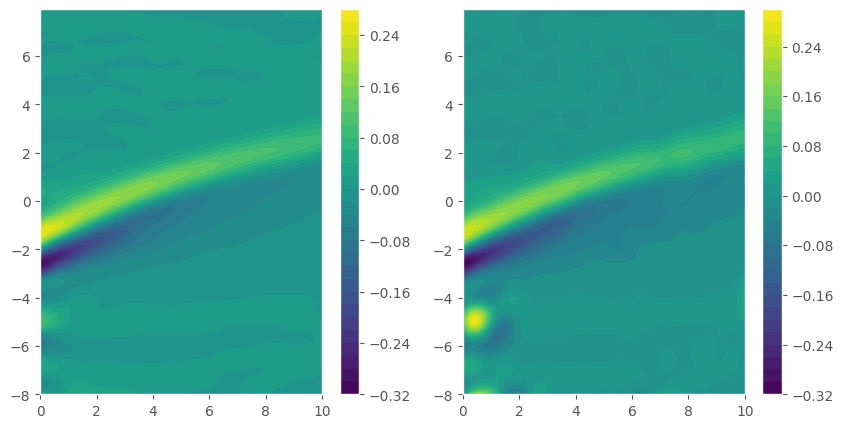

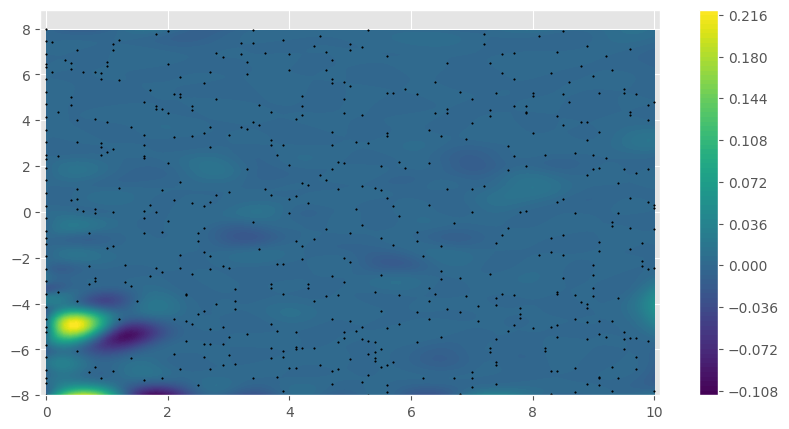

Equation fit error norm  2.3550485327412245


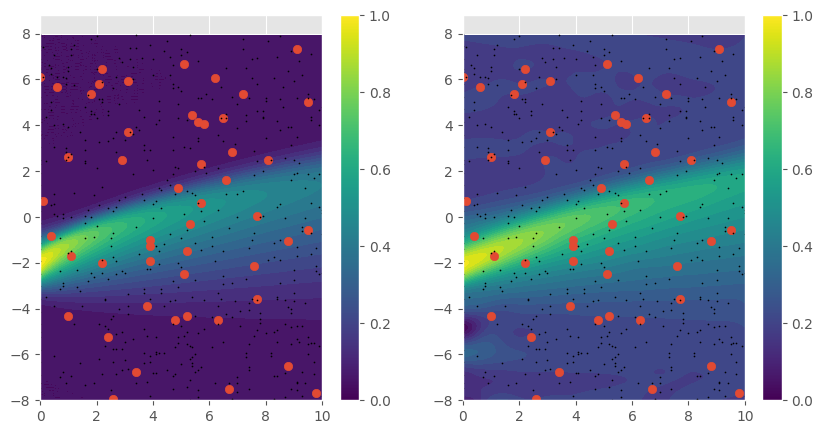

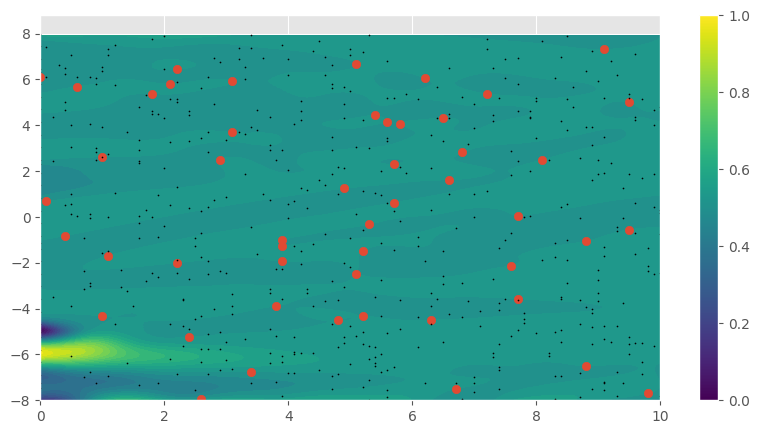

In [45]:
fine_features = EqnModel.single_eqn_features(u_model,u_sol,X_star)
input_features = EqnModel.single_eqn_features(u_model,u_sol,tx_all)

P_parameters = p_adjusted[u_model.num_params:]

feature_predicted_ut = P_model.predict_new(fine_features,input_features,P_parameters)
ut_target = u_model.evaluate_operators((dt_k,),X_star,u_sol)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.tricontourf(X_star[:,0],X_star[:,1],feature_predicted_ut,30)
plt.colorbar()
plt.subplot(1,2,2)
plt.tricontourf(X_star[:,0],X_star[:,1],ut_target,30)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,5))
plt.tricontourf(X_star[:,0],X_star[:,1],ut_target - feature_predicted_ut,100)
plt.xlim(-0.1,10.1)
# plt.ylim(-10,10)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 1)
plt.show()

print("Equation fit error norm ", jnp.linalg.norm(ut_target - feature_predicted_ut))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.tricontourf(X_star[:,0],X_star[:,1],u_true,30)
plt.scatter(tx_obs[:,0],tx_obs[:,1])
plt.scatter(tx_all[:,0],tx_all[:,1],s=0.5,c='black')
plt.colorbar()
plt.subplot(1,2,2)
plt.tricontourf(X_star[:,0],X_star[:,1],u_model.point_evaluate(X_star,u_sol),30)
plt.scatter(tx_obs[:,0],tx_obs[:,1])
plt.scatter(tx_all[:,0],tx_all[:,1],s=0.5,c='black')
plt.colorbar()
plt.show()

error = u_model.point_evaluate(X_star,u_sol) - u_true

plt.figure(figsize=(10,5))
plt.tricontourf(X_star[:,0],X_star[:,1],error/(jnp.abs(u_true) + 1e-3),30)
plt.scatter(tx_obs[:,0],tx_obs[:,1])
plt.scatter(tx_all[:,0],tx_all[:,1],s=0.5,c='black')
plt.colorbar()
plt.show()
